In [262]:
from fenics import *
from dolfin import *
#from mshr import *
import matplotlib.pyplot as plt

comm = MPI.comm_world
rank = MPI.rank(comm)
import numpy as np

In [263]:
data = HDF5File(comm, f"data_mpi_time_1800_D_1.99_count_49.h5", 'r')

mesh = Mesh()
data.read(mesh, "mesh", False)



In [264]:
nx = 60
ny = 100
LX = 120 
LY = 200

# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    def inside(self, x, on_boundary):
        return bool((near(x[0], 0) or near(x[1], 0)) and
                (not ((near(x[0], 0) and near(x[1], LY)) or
                        (near(x[0], LX) and near(x[1], 0)))) and on_boundary)

    def map(self, x, y):
        if near(x[0], LX) and near(x[1], LY):
            y[0] = x[0] - LX
            y[1] = x[1] - LY
        elif near(x[0], LX):
            y[0] = x[0] - LX
            y[1] = x[1]
        else:   # near(x[1], 127)
            y[0] = x[0]
            y[1] = x[1] - LY

In [265]:
V = VectorElement("Lagrange", mesh.ufl_cell(), 1, dim = 2)
Q = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
MFS = FunctionSpace(mesh, MixedElement([Q, V]), constrained_domain = PeriodicBoundary())

VFS = FunctionSpace(mesh, V, constrained_domain = PeriodicBoundary())
FS  = FunctionSpace(mesh, Q, constrained_domain = PeriodicBoundary())

u_new = Function(MFS) 
w = Function(FS)

(rho_new, tau_new) = split(u_new)

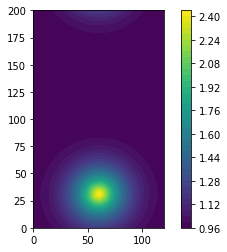

In [314]:
t = 0
data.read(u_new, f"u_new/Vector/vector_{t}")

c = plot(rho_new)
plt.colorbar(c)

In [315]:
taux = project(tau_new[0]/rho_new, FS)
tauy = project(tau_new[1]/rho_new, FS)

# taux = project(tau_new[0], FS)
# tauy = project(tau_new[1], FS)

theta = Function(FS)

for i in range(len(theta.vector()[:])):
    theta.vector()[i] = np.arctan2(tauy.vector()[i], taux.vector()[i])

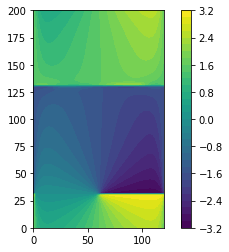

In [316]:
c = plot(theta)
plt.colorbar(c)

In [317]:
rho = project(rho_new, FS)

# Evaluate the function at mesh vertices
vertex_values = rho.compute_vertex_values(mesh)

# Find the index of the maximum value
max_value_index = vertex_values.argmax()

# Get the coordinates of the vertex with the maximum value
max_vertex_coords = mesh.coordinates()[max_value_index]

In [318]:
x0 = max_vertex_coords[0]
y0 = max_vertex_coords[1]

print(y0)

32.0


In [319]:
phi = Expression("atan2(x[1] - y0,x[0] - x0)", element = FS.ufl_element(), x0 = x0, y0 = y0)

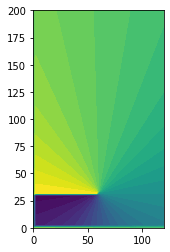

In [320]:
phi_ = interpolate(phi, FS)
plot(phi_)

In [321]:


x = []
y = []

test = []
for i in range(len(rho.vector()[:])):
    if(rho.vector()[i] > 1.5):
        x.append(phi_.vector()[i])
        y.append(theta.vector()[i])
        test.append(rho.vector()[i])
    else:
        test.append(0)

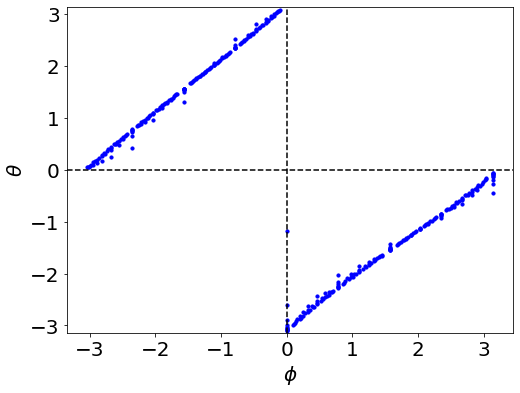

In [333]:
# Sort the x array and store the corresponding order indices
sorted_indices = sorted(range(len(x)), key=lambda k: x[k])
sorted_x = [x[i] for i in sorted_indices]
sorted_y = [y[i] for i in sorted_indices]
plt.figure(figsize = (8, 6))
# Create the plot
plt.scatter(sorted_x, sorted_y, color='b', s=10)


plt.xlabel(r'$\phi $', fontsize = 20)
plt.ylabel(r'$\theta $', fontsize = 20)
plt.ylim([-np.pi, +np.pi])
plt.axvline(x = 0, linestyle = '--', color = 'k')
plt.axhline(y = 0, linestyle = '--', color = 'k')
plt.tick_params(axis = 'both', labelsize = 20)
plt.show()




In [187]:
u = Function(FS)

In [188]:
u.vector().set_local(test)

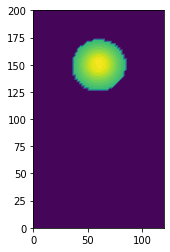

In [189]:
plot(u)